# 项目说明

**项目名称**

工业蒸汽量预测

**赛题背景**

火力发电的基本原理是：燃料在燃烧时加热水生成蒸汽，蒸汽压力推动汽轮机旋转，然后汽轮机带动发电机旋转，产生电能。在这一系列的能量转化中，影响发电效率的核心是锅炉的燃烧效率，即燃料燃烧加热水产生高温高压蒸汽。锅炉的燃烧效率的影响因素很多，包括锅炉的可调参数，如燃烧给量，一二次风，引风，返料风，给水水量；以及锅炉的工况，比如锅炉床温、床压，炉膛温度、压力，过热器的温度等。

**赛题描述**

经脱敏后的锅炉传感器采集的数据（采集频率是分钟级别），根据锅炉的工况，预测产生的蒸汽量。

**数据说明**

1. 训练数据（train.txt）
2. 测试数据（test.txt）
3. 字段”V0”-“V37”，这38个字段是作为特征变量，”target”作为目标变量。
4. 排名结果依据预测结果的 MSE（mean square error）。

**结果提交**

选手需要提交测试数据的预测结果（txt格式，只有1列预测结果）。

**结果评估**

预测结果以mean square error作为评判标准。

**大赛网址**

https://tianchi.aliyun.com/competition/entrance/231693/introduction?spm=5176.12281925.0.0.5d777137xcPfn6

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import mean_squared_error

In [ ]:
import torch.nn as nn
import torch
from torch import optim

# 数据探索

In [ ]:
data_train = pd.read_csv('./zhengqi_train.txt', sep='\t')
data_test = pd.read_csv('./zhengqi_test.txt', sep='\t')
labels = data_train['target']
train_set = data_train.drop('target', axis=1)

In [ ]:
data_train.head(20).append(data_train.tail(20))

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V29,V30,V31,V32,V33,V34,V35,V36,V37,target
0,0.566,0.016,-0.143,0.407,0.452,-0.901,-1.812,-2.360,-0.436,-2.114,...,0.136,0.109,-0.615,0.327,-4.627,-4.789,-5.101,-2.608,-3.508,0.175
1,0.968,0.437,0.066,0.566,0.194,-0.893,-1.566,-2.360,0.332,-2.114,...,-0.128,0.124,0.032,0.600,-0.843,0.160,0.364,-0.335,-0.730,0.676
2,1.013,0.568,0.235,0.370,0.112,-0.797,-1.367,-2.360,0.396,-2.114,...,-0.009,0.361,0.277,-0.116,-0.843,0.160,0.364,0.765,-0.589,0.633
3,0.733,0.368,0.283,0.165,0.599,-0.679,-1.200,-2.086,0.403,-2.114,...,0.015,0.417,0.279,0.603,-0.843,-0.065,0.364,0.333,-0.112,0.206
4,0.684,0.638,0.260,0.209,0.337,-0.454,-1.073,-2.086,0.314,-2.114,...,0.183,1.078,0.328,0.418,-0.843,-0.215,0.364,-0.280,-0.028,0.384
5,0.445,0.627,0.408,0.220,0.458,-1.056,-1.009,-1.896,0.481,-2.114,...,0.454,0.674,0.358,0.618,-0.843,-0.290,0.364,-0.191,-0.883,0.060
6,0.889,0.416,0.640,0.356,0.224,-0.893,-0.812,-1.823,0.729,-2.114,...,0.454,0.081,0.243,0.468,-0.843,-0.290,0.364,-0.155,-1.318,0.415
7,0.984,0.529,0.704,0.438,0.258,-0.917,-0.682,-1.721,0.753,-2.114,...,0.139,-0.050,0.428,-0.119,-0.843,-0.290,0.364,0.100,-0.899,0.609
8,0.948,0.850,0.584,0.459,0.591,-0.523,-0.591,-1.524,0.763,-2.114,...,0.188,0.467,0.597,-0.057,-0.843,-0.290,0.364,0.053,-0.553,0.981
9,1.157,1.055,0.638,0.617,1.483,-0.731,-0.612,-1.524,0.968,-2.114,...,0.860,0.456,0.916,0.039,-0.843,-0.290,0.364,0.151,-1.157,0.818


In [ ]:
data_test.head().append(data_test.tail())

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37
0,0.368,0.380,-0.225,-0.049,0.379,0.092,0.550,0.551,0.244,0.904,...,-0.449,0.047,0.057,-0.042,0.847,0.534,-0.009,-0.190,-0.567,0.388
1,0.148,0.489,-0.247,-0.049,0.122,-0.201,0.487,0.493,-0.127,0.904,...,-0.443,0.047,0.560,0.176,0.551,0.046,-0.220,0.008,-0.294,0.104
2,-0.166,-0.062,-0.311,0.046,-0.055,0.063,0.485,0.493,-0.227,0.904,...,-0.458,-0.398,0.101,0.199,0.634,0.017,-0.234,0.008,0.373,0.569
3,0.102,0.294,-0.259,0.051,-0.183,0.148,0.474,0.504,0.010,0.904,...,-0.456,-0.398,1.007,0.137,1.042,-0.040,-0.290,0.008,-0.666,0.391
4,0.300,0.428,0.208,0.051,-0.033,0.116,0.408,0.497,0.155,0.904,...,-0.458,-0.776,0.291,0.370,0.181,-0.040,-0.290,0.008,-0.140,-0.497
1920,-1.362,-1.553,-3.096,-0.444,0.381,1.375,-4.854,-5.331,-4.074,-3.838,...,0.525,0.171,-4.488,-5.793,-4.050,-1.187,-0.852,-2.131,-2.564,0.597
1921,-2.698,-3.452,-3.620,-1.066,-1.385,1.378,-4.927,-5.103,-4.393,-1.683,...,-0.446,1.297,-0.613,-7.698,-0.674,-1.187,-0.852,-2.131,-2.564,1.215
1922,-2.615,-3.564,-3.402,-0.422,-1.272,1.121,-4.223,-4.315,-5.196,-3.407,...,-0.447,0.552,0.125,-6.111,0.275,-1.851,-1.548,-1.537,-2.544,1.612
1923,-2.661,-3.646,-3.271,-0.699,-1.270,1.116,-3.716,-3.809,-4.735,-2.976,...,-0.447,0.318,1.086,-5.268,0.683,-1.645,-1.471,-1.537,-2.549,1.431
1924,-2.321,-3.037,-3.214,-1.594,-0.910,1.259,-3.616,-3.747,-4.368,-2.976,...,-0.442,0.323,-0.774,-5.211,1.618,-1.703,-1.471,-1.537,-1.123,1.988


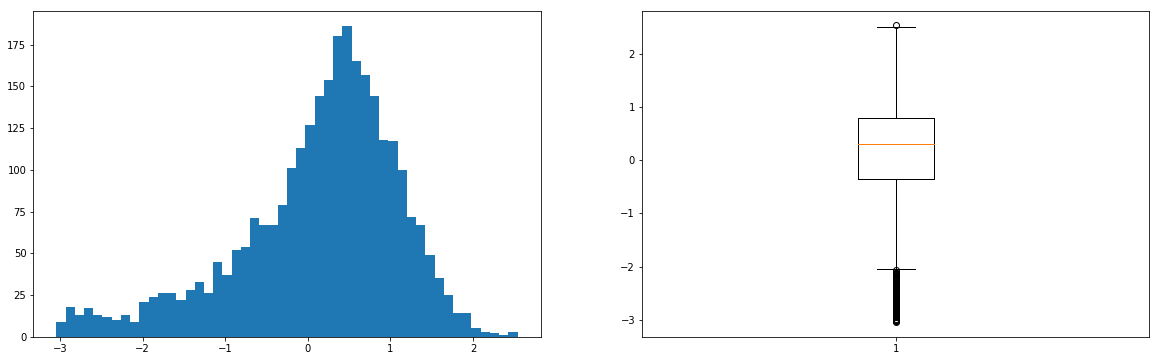

In [ ]:
# 标签分布
fig, ax = plt.subplots(1, 2, figsize=(20,6))
ax[0].hist(labels.values, bins=50)
ax[1].boxplot(labels.values)
plt.show()

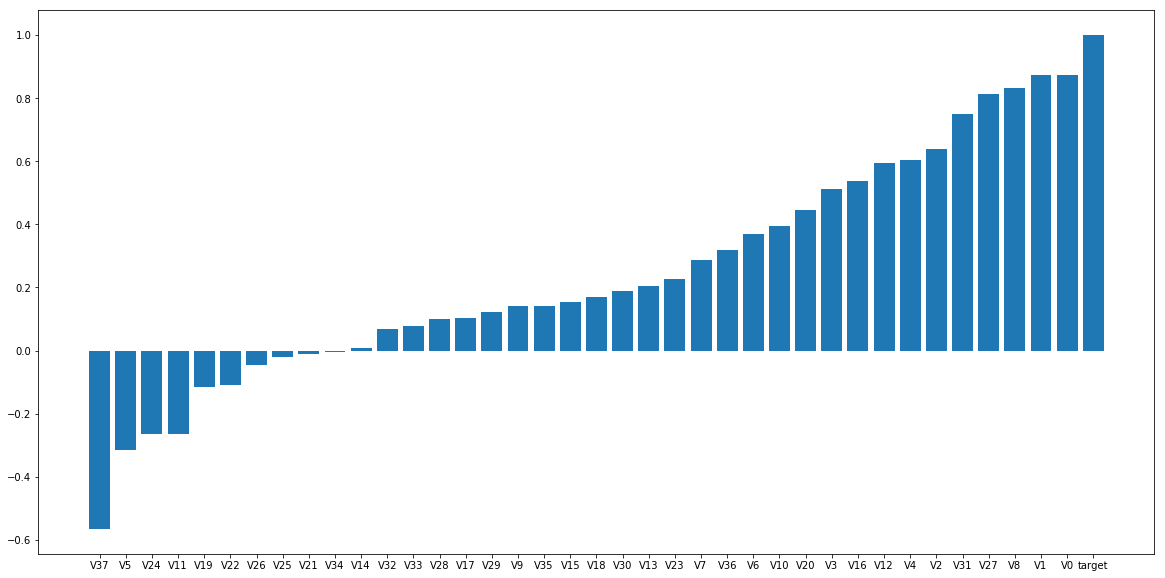

In [ ]:
# 各特征与target的相关性
plt.figure(figsize=(20, 10))
corr_data = data_train.corrwith(data_train['target'])
corr_data = corr_data.sort_values()
plt.bar(corr_data.index, corr_data)
plt.show()

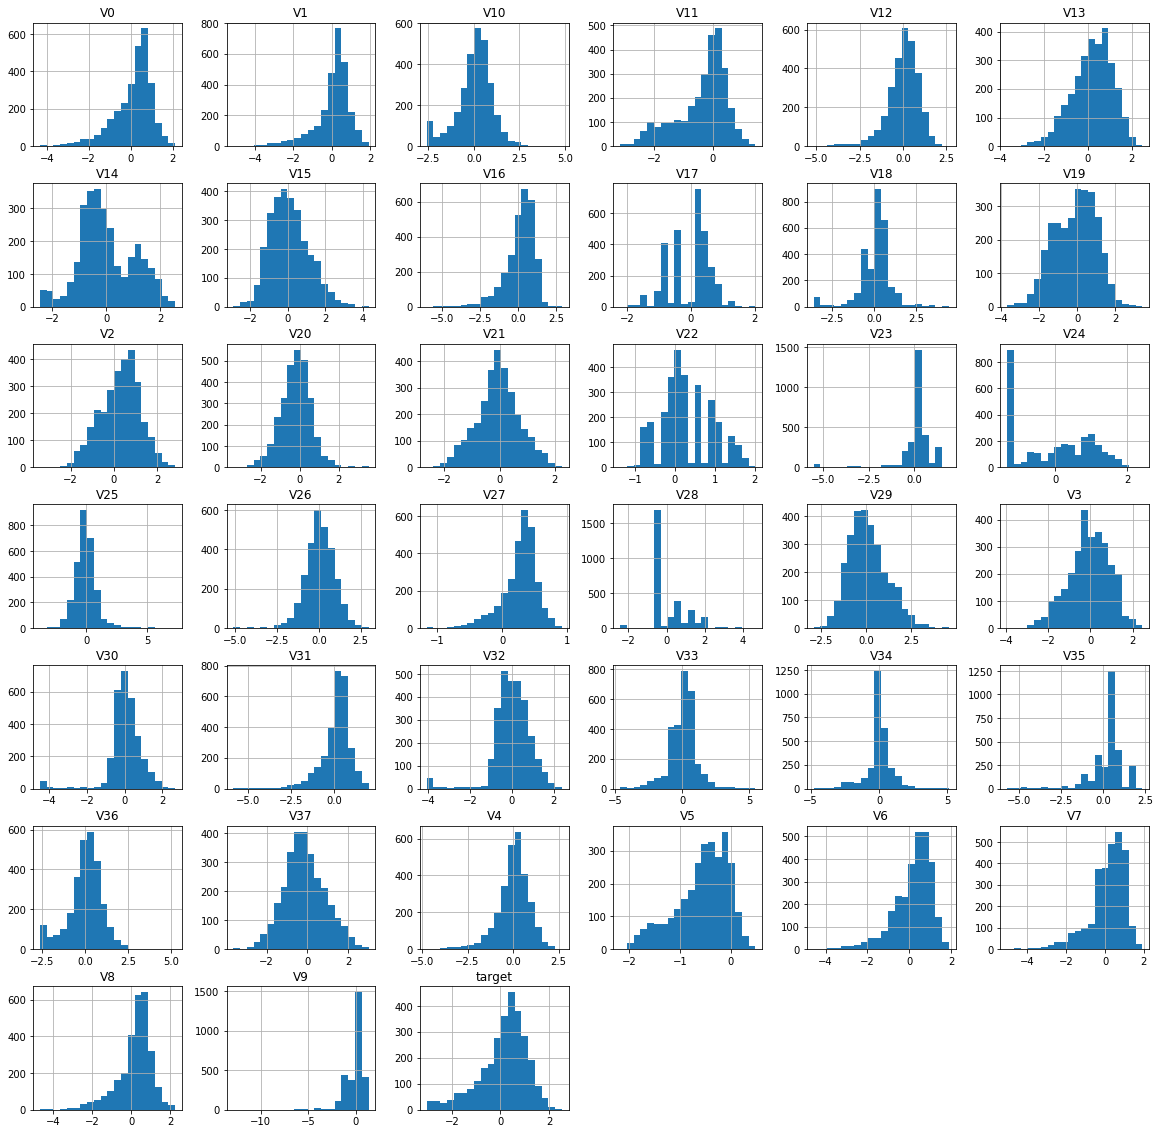

In [ ]:
# 特征值分布
data_train.hist(bins=20, figsize=(20, 20))
plt.show()

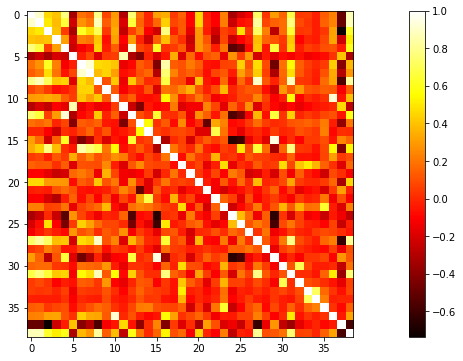

In [ ]:
# 相关性检查
plt.figure(figsize=(20, 6))
plt.imshow(data_train.corr(), cmap='hot')
plt.colorbar()
plt.show()

# 特征工程

In [ ]:
grid_parameters = {}

# 特横构造
# feature_building = Pipeline([])

# 特征选择
# feature_selection = Pipeline([])

# 特征降维
# feature_reduce = Pipeline([])

# 标准化数据
ready_pipe = Pipeline([
#     ('build', feature_building),
#     ('select', feature_selection),
#     ('reduce', feature_reduce)
    ('standar', StandardScaler())
])
grid_parameters.update({'ready__standar__with_mean': [True, False], 'ready__standar__with_std': [True, False]})

# 数据拆分

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train_set, labels, test_size=0.33, random_state=1234)

# 模型训练

## 传统机器学习

In [ ]:
grid_pipe = Pipeline([
    ('ready', ready_pipe),
    ('estimator', LinearRegression())
])
grid_parameters.update({'estimator__normalize': [True, False], 'estimator__fit_intercept': [True, False]})
grid = GridSearchCV(grid_pipe, grid_parameters, cv=5)
grid.fit(X_train, y_train)
print('best_params', grid.best_params_)
predict = grid.predict(X_test)
print('MSE：{:.4f}'.format(mean_squared_error(predict, y_test)))

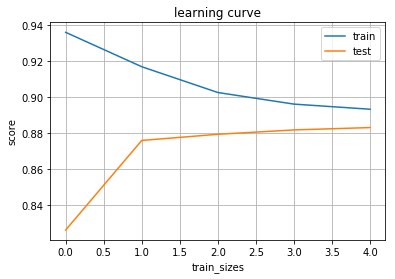

In [ ]:
#模型评估
grid.verbose = False
train_sizes, train_scores, test_scores = learning_curve(grid, X_train, y_train, cv=3)
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)  
plt.plot(train_scores_mean, label='train')
plt.plot(test_scores_mean, label='test')
plt.xlabel('train_sizes')
plt.ylabel('score')
plt.title('learning curve')
plt.legend()
plt.grid()
plt.show()

In [ ]:
# 结果输出
result = grid.predict(data_test)
result.tofile('./test_result.txt', sep='\n')
result[:20].reshape(-1,1)

array([[ 0.89106616],
       [ 0.69398656],
       [ 0.71553895],
       [ 0.26300408],
       [ 0.50035413],
       [ 0.33609757],
       [ 0.58490734],
       [ 0.66433988],
       [ 0.89222295],
       [ 1.11619104],
       [ 1.13051392],
       [ 1.12216862],
       [-1.02559701],
       [-1.22157807],
       [-0.3973184 ],
       [-1.24028426],
       [-0.35977111],
       [-1.49436138],
       [-0.48977052],
       [ 0.1370297 ]])

## 神经网络

In [ ]:
X_train_tensor = X_train.astype(np.float32)
X_train_tensor = torch.from_numpy(X_train_tensor.values)

y_train_tensor = y_train.astype(np.float32)
y_train_tensor = torch.from_numpy(y_train_tensor.values).unsqueeze(1)

X_test_tensor = X_test.astype(np.float32)
X_test_tensor = torch.from_numpy(X_test_tensor.values)

y_test_tensor = y_test.astype(np.float32)
y_test_tensor = torch.from_numpy(y_test_tensor.values).unsqueeze(1)

In [ ]:
model = nn.Sequential(
    nn.Linear(38, 16),
    nn.ReLU(),
    nn.Linear(16, 4),
    nn.ReLU(),
    nn.Linear(4, 1),
)

loss_funtion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

loss_record = []
for i in range(2000):
    y_pre = model(X_train_tensor)
    loss = loss_funtion(y_pre, y_train_tensor)
    loss_record.append(round(loss.item(), 2))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

loss

tensor(0.0338, grad_fn=<MseLossBackward>)

In [ ]:
model.eval()
y = model(X_test_tensor)
loss_funtion(y, y_test_tensor)

tensor(0.1801, grad_fn=<MseLossBackward>)

In [ ]:
# 结果输出
test_tensor = torch.from_numpy(data_test.astype(np.float32).values)
model.eval()
result = model(test_tensor).detach().numpy()
result = pd.DataFrame(result)
result.to_csv('./test_result_tor.txt', header=False, index=False)